### Simulation Rountine for Figure 2, section 6.2

In [3]:
import torch
from data_prep import load_data
import numpy as np
import torch.nn.functional as F

# ======================================================
# 0. Setup device (GPU if available)
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ======================================================
# 1. Load data and move to GPU
# ======================================================
X, Y, data = load_data('./cs-training.csv')
n = X.shape[0]
d = X.shape[1] - 1

X_train = torch.tensor(X[:, 1:], dtype=torch.float32, requires_grad=True, device=device)
y_train = torch.tensor(Y, dtype=torch.float32, device=device)
theta = torch.randn(d, dtype=torch.float32, requires_grad=True, device=device)
X_ori = X_train.clone().detach().to(device)

# ======================================================
# 2. Define losses and gradients
# ======================================================
def loss_fn(X_t, y, th):
    return F.binary_cross_entropy_with_logits(X_t @ th, y)

def loss_grad(X_t, y, th, create_graph=False):
    loss = loss_fn(X_t, y, th)
    return torch.autograd.grad(loss, th, create_graph=create_graph)[0]


def lr_grad(X, y, theta):
    # Compute mixed second derivative directly
    def loss_fn_X(X_t):
        return F.binary_cross_entropy_with_logits(X_t @ theta, y)

    def loss_fn_theta(theta_t):
        return F.binary_cross_entropy_with_logits(X @ theta_t, y)

    # ∂²L/(∂X∂θ)
    J = torch.autograd.functional.jacobian(
        lambda X_t: torch.autograd.grad(loss_fn_X(X_t), theta, create_graph=True)[0],
        X, create_graph=True
    )
    H = torch.autograd.functional.hessian(loss_fn_theta, theta, create_graph=True)
    g = torch.autograd.grad(loss_fn_theta(theta), theta, create_graph=True)[0]
    return J, H, g


# ======================================================
# 3. Utility and implicit gradient terms
# ======================================================
def util_fun(X, y, theta, align):
    return F.binary_cross_entropy_with_logits(X @ theta, y) - align * torch.norm(theta)**2

def util_grad(X, y, theta, align):
    u_val = util_fun(X, y, theta, align)
    util_grad_on_x = torch.autograd.grad(u_val, X, create_graph=True)[0]
    util_grad_on_theta = torch.autograd.grad(u_val, theta, create_graph=True)[0]

    J, H, g = lr_grad(X, y, theta)  # J = ∂²L/∂X∂θ, H = ∂²L/∂θ²
    H_inv = torch.linalg.pinv(H)
    correction = torch.einsum('ijk,k->ij', J, H_inv @ util_grad_on_theta)
    return util_grad_on_x - correction.T




# ======================================================
# 4. Iterative solvers
# ======================================================
def solve_theta(X, y, theta=None, n_iters=200, lr=0.1):
    # Always start with a leaf tensor that tracks gradients
    if theta is None:
        theta = torch.randn(X.shape[1], device=device, requires_grad=True)
    else:
        theta = theta.detach().clone().to(device).requires_grad_(True)

    for i in range(n_iters):
        # --- recompute loss from current θ ---
        loss = F.binary_cross_entropy_with_logits(X @ theta, y)

        # --- ensure autograd is tracking this graph ---
        if not theta.requires_grad:
            theta.requires_grad_(True)

        # --- compute grad safely ---
        grad = torch.autograd.grad(loss, theta, create_graph=False, retain_graph=False)[0]


        # --- manual update (re-enable grad tracking for next iter) ---
        theta = (theta - lr * grad).detach().clone().requires_grad_(True)

        #if i == n_iters-1:
            #print(torch.norm(grad))

    return theta





def solve_x(X, y, theta, align, ind=[1], n_iters=100, lr=2):
    mask = torch.zeros_like(X, device=device)
    mask[:, ind] = 1
    for i in range(n_iters):
        util = util_fun(X, y, theta, align)
        grad = torch.autograd.grad(util, X, create_graph=True)[0]
        grad = torch.multiply(mask, grad)
        with torch.no_grad():
            X += lr * grad
        if i == n_iters-1:
            print(torch.norm(grad))
        X.requires_grad_()
    return X

def performative_stable(X, y, theta, align, n_iter=100):
    X = X.to(device).requires_grad_(True)
    y = y.to(device)
    theta = theta.to(device).requires_grad_(True)
    for i in range(n_iter):
        theta = solve_theta(X, y, theta, n_iters=200)
        X = solve_x(X, y, theta, align, n_iters=200)

    return theta, X

def stackel_eq(X, y, theta, align, ind=[1], n_iter=100, lr=10):
    X = X.clone().detach().to(device).requires_grad_(True)
    theta = theta.clone().detach().to(device).requires_grad_(True)
    mask = torch.zeros_like(X, device=device)
    mask[:, ind] = 1

    if align < 0.03:
        lr = 20
        n_iter = 500
    for i in range(n_iter):
        if i > 200:
            lr = 10
        if i > 300:
            lr = 1
        if i > 400:
            lr = 0.1

        # 1. Compute the best-response learner
        theta_star = solve_theta(X, y, theta, n_iters= 200)   # new θ*, detached

        # 2. Compute implicit gradient wrt X
        grad_X = util_grad(X, y, theta_star, align)  # includes ∂θ*/∂X term

        # 3. Apply selective update
        grad_X = grad_X * mask
        with torch.no_grad():
            X += lr * grad_X

        X.requires_grad_(True)

    return X, theta_star

Using device: cuda


In [4]:





# ======================================================
# 5. Run on GPU
# ======================================================

align_tests = np.linspace(0,1, 10)
rec_dict = {'align': [], 'u_ps': [], 'u_se': [], 'align_inner_prod': []}

for align in align_tests:
    rec_dict['align'].append(align)

    # stackelberg eq
    theta = torch.ones_like(theta)
    X_sharp, theta_sharp = stackel_eq(X_train, y_train, theta, align, n_iter=200, lr = 0.05)
    u_se = util_fun(X_sharp, y_train, theta_sharp, align)
    
    # performative stable
    theta = torch.ones_like(theta)
    theta_star, X_star = performative_stable(X_train, y_train, theta, align, n_iter = 200)
    u_ps = util_fun(X_star, y_train, theta_star, align)

    # Compute inner prod
    J, H, _ = lr_grad(X_star, y_train, theta_star)
    H_inv = torch.linalg.pinv(H)
    g = torch.autograd.grad(u_ps, theta_star)[0]
    #print(J)
    inner_prod = torch.einsum('ijk,k->ij', J, H_inv @ g)
    

    rec_dict['u_ps'].append(u_ps)
    rec_dict['u_se'].append(u_se)
    rec_dict['align_inner_prod'].append(torch.norm(inner_prod)**2)


    print(u_ps, u_se, torch.norm(inner_prod)**2)

KeyboardInterrupt: 

In [14]:
class LongLineHandler(HandlerTuple):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        """
        Draw long parallel lines in the legend, preserving
        each line's original color and linestyle.
        """
        start = 0.0
        end = width * 0.9  # make lines long

        # vertical layout for the two lines
        ymid = height / 2
        dy = height * 0.2

        artists = []
        y_positions = [ymid + dy, ymid - dy]

        # create one line per handle
        for (orig, y) in zip(orig_handle, y_positions):
            line = Line2D(
                [start, end], [y, y],
                color=orig.get_color(),
                linestyle=orig.get_linestyle(),   # ← IMPORTANT FIX
                linewidth=orig.get_linewidth()
            )
            line.set_transform(trans)
            artists.append(line)

        return artists


def multicolor_ylabel(ax,list_of_strings,list_of_colors,axis='x',anchorpad=0,**kw):
    """this function creates axes labels with multiple colors
    ax specifies the axes object where the labels should be drawn
    list_of_strings is a list of all of the text items
    list_if_colors is a corresponding list of colors for the strings
    axis='x', 'y', or 'both' and specifies which label(s) should be drawn"""
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

    # x-axis label
    if axis=='x' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',**kw)) 
                    for text,color in zip(list_of_strings,list_of_colors) ]
        xbox = HPacker(children=boxes,align="center",pad=0, sep=5)
        anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=anchorpad,frameon=False,bbox_to_anchor=(0.2, -0.09),
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_xbox)

    # y-axis label
    if axis=='y' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',rotation=90,**kw)) 
                     for text,color in zip(list_of_strings[::-1],list_of_colors) ]
        ybox = VPacker(children=boxes,align="center", pad=0, sep=5)
        anchored_ybox = AnchoredOffsetbox(loc=3, child=ybox, pad=anchorpad, frameon=False, bbox_to_anchor=(-0.10, 0.0), 
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_ybox)


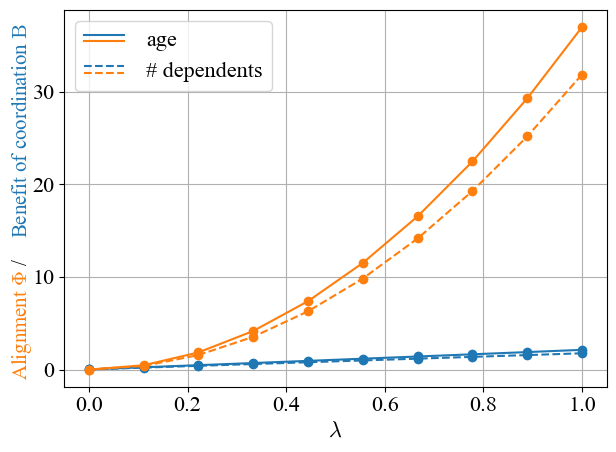

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.legend_handler import HandlerTuple

fig, ax = plt.subplots()
# Plotting fonts setup
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 16}) 

df = pd.read_csv('rec_alignment_vs_utility_gap_age.csv')
df2 = pd.read_csv('rec_alignment_vs_utility_gap_nd.csv')
plt.plot(df['align'], df['u_se'] - df['u_ps'], label = r'$U(h^\sharp) - U(h^*)$, Age', marker='o', c = 'tab:blue')
plt.plot(df2['align'], df2['u_se'] - df2['u_ps'], label = r'$U(h^\sharp) - U(h^*)$, Num_Dep', marker='o', c = 'tab:blue', ls = '--')
plt.plot(df['align'], df['align_inner_prod'], label = 'Alignment Metric, Age', marker='o', c = 'tab:orange')
plt.plot(df2['align'], df2['align_inner_prod'], label = 'Alignment Metric, Num_Dep', marker='o', c = 'tab:orange', ls = '--')
plt.xlabel(r'$\lambda$')
# plt.ylabel('Utility')
multicolor_ylabel(ax,('Alignment $\Phi$', '/', r'Benefit of coordination $\mathrm{B}$'),('tab:blue','k','tab:orange'),axis='y',size=15,)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
# Legend composite handle
h1 = Line2D([], [], color='tab:blue', linestyle='--')
h2 = Line2D([], [], color='tab:orange', linestyle='--')
handle1 = (h1, h2)

h3 = Line2D([], [], color='tab:blue')
h4 = Line2D([], [], color='tab:orange')
handle2 = (h3, h4)


ax.legend(
    [handle2, handle1],
    ["age", "# dependents"],
    handler_map={tuple: LongLineHandler()}
)
plt.grid()
plt.tight_layout()
plt.savefig('alignment_vs_utility_gap.pdf')
plt.savefig('alignment_vs_utility_gap.png')

In [14]:
pd.read_csv('rec_alignment_vs_utility_gap_age.csv')

,align,u_ps,u_se,align_inner_prod
0,0.000000,0.625213,0.638714,1.345405e-11
1,0.111111,-0.024984,0.189131,3.932850e-01
2,0.222222,-0.675135,-0.267293,1.573002e+00
3,0.333333,-1.325309,-0.723770,3.539083e+00
4,0.444444,-1.975483,-1.180394,6.291408e+00
5,0.555556,-2.625657,-1.637165,9.829859e+00
6,0.666667,-3.275829,-2.094083,1.415433e+01
7,0.777778,-3.926001,-2.551147,1.926473e+01
8,0.888889,-4.576173,-3.008363,2.516091e+01
9,1.000000,-5.226343,-3.465722,3.184282e+01
